In [2]:
import os

os.environ["HUGGINGFACE_HUB_CACHE"] = "/data/sshadmin/bocheng/.cache/huggingface/hub/"
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [8]:
# 载入一个预训练过的管线
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)
# 使用DDIM调度器，仅用40步生成一些图片
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)
# 将随机噪声作为出发点
x = torch.randn(8, 3, 256, 256).to(device)

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config.json: 100%|██████████| 938/938 [00:00<00:00, 2.25MB/s]
diffusion_pytorch_model.safetensors: 100%|██████████| 455M/455M [00:46<00:00, 9.72MB/s]
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]
40it [00:05,  7.75it/s]


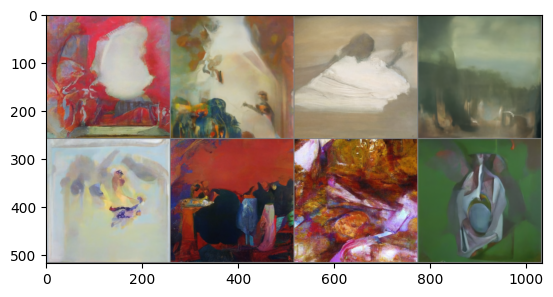

In [2]:



# 使用一个最简单的采样循环
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
# 查看生成结果，如图5-10所示
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [3]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """给定一个RGB值，返回一个损失值，用于衡量图片的像素值与目标颜色相差多少；
    这里的目标颜色是一种浅蓝绿色，对应的RGB值为(0.1, 0.9, 0.5)"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # 首先对target_color进行归一化，使它的取值区间为(-1, 1)
    target = target[None, :, None, None]  # 将所生成目标张量的形状改为(b, c, h, w)，以适配输入图像images的
    # 张量形状
    error = torch.abs(images - target).mean()  # 计算图片的像素值以及目标颜色的均方误差
    return error

0it [00:00, ?it/s]

2it [00:00, 10.27it/s]

0 loss: 29.65845489501953


12it [00:01, 10.26it/s]

10 loss: 11.819438934326172


22it [00:02, 10.38it/s]

20 loss: 11.060638427734375


32it [00:03, 10.38it/s]

30 loss: 11.226463317871094


40it [00:03, 10.34it/s]


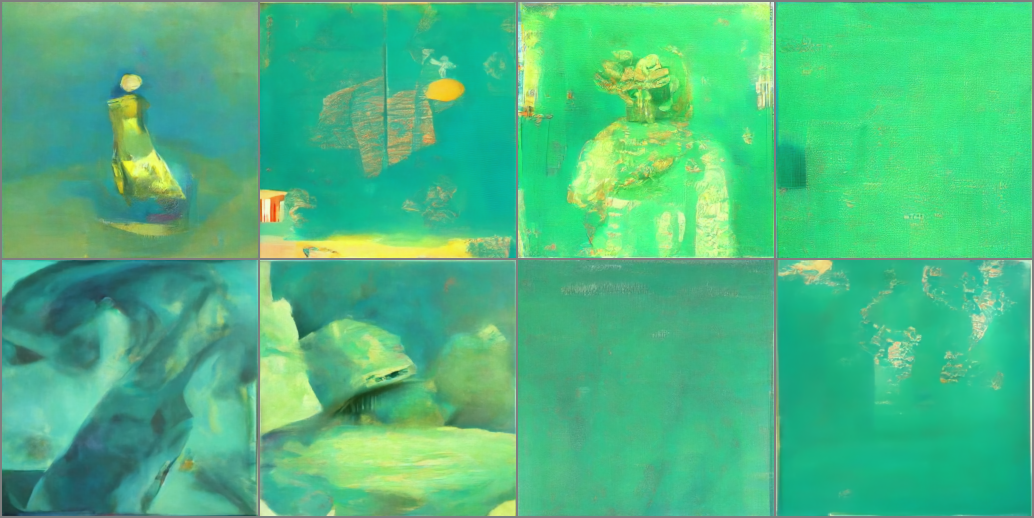

In [5]:
guidance_loss_scale=40
x=torch.randn(8,3,256,256).to(device)
for i,t, in tqdm(enumerate(scheduler.timesteps)):
    model_input=scheduler.scale_model_input(x,t)
    with torch.no_grad():
        noise_pred=image_pipe.unet(model_input,t)["sample"]
    x=x.detach().requires_grad_()
    x0=scheduler.step(noise_pred,t,x).pred_original_sample
    loss=color_loss(x0)*guidance_loss_scale
    if i%10==0:
        print(i,"loss:",loss.item())
    cond_grad=-torch.autograd.grad(loss,x)[0]
    x=x.detach()+cond_grad
    x=scheduler.step(noise_pred,t,x).prev_sample
grid=torchvision.utils.make_grid(x,nrow=4)
im=grid.permute(1,2,0).cpu().clip(-1,1)*0.5+0.5
Image.fromarray(np.array(im*255).astype(np.uint8))

1it [00:00,  3.38it/s]

0 loss: 30.628353118896484


12it [00:01,  9.08it/s]

10 loss: 20.791343688964844


22it [00:02,  9.08it/s]

20 loss: 20.168540954589844


32it [00:03,  9.13it/s]

30 loss: 20.233821868896484


40it [00:04,  8.85it/s]


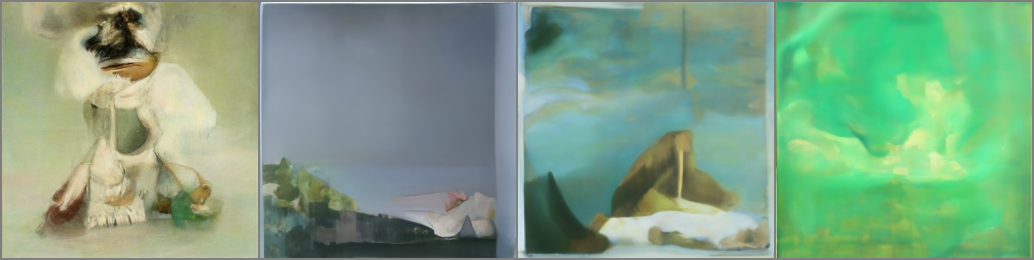

In [6]:
# 第二种方法：在模型预测前设置好x.requires_grad
guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # 首先设置好requires_grad
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)
    # 预测
    noise_pred = image_pipe.unet(model_input, t)["sample"]
    # 得到“去噪”后的图像
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample
    # 计算损失值
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())
    # 获取梯度
    cond_grad = -torch.autograd.grad(loss, x)[0]
    # 根据梯度修改x
    x = x.detach() + cond_grad
    # 使用调度器更新x
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [6]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32"
)
clip_model.to(device)
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomAffine(5),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

def clip_loss(image,text_features):
    image_features=clip_model.encode_image(tfms(image))
    input_normed=torch.nn.functional.normalize(image_features.unsqueeze(1),dim=2)
    embed_normed=torch.nn.functional.normalize(text_features.unsqueeze(0),dim=2)
    dists=(input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2))
    return dists.mean()

0it [00:00, ?it/s]/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
2it [00:01,  2.19it/s]

Step: 0 , Guidance loss: 9.713103294372559


27it [00:04,  6.29it/s]

Step: 25 , Guidance loss: 9.692441940307617


50it [00:08,  5.82it/s]


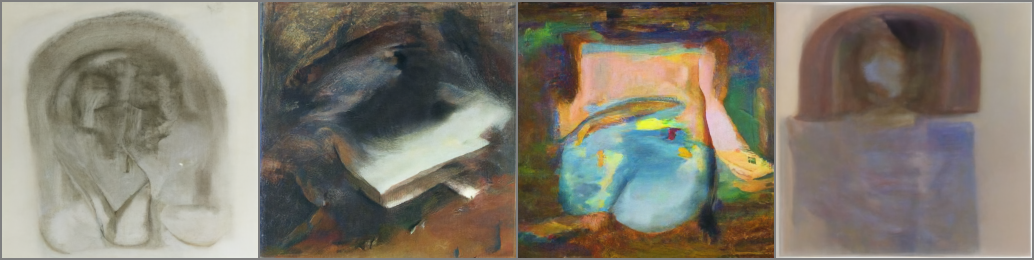

In [9]:
prompt = "Red Rose (still life), red flower painting"
# 读者可以探索一下这些超参数的影响
guidance_scale = 8
n_cuts = 4
# 这里使用稍微多一些的步数
scheduler.set_timesteps(50)
# 使用CLIP从提示文字中提取特征
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)
x = torch.randn(4, 3, 256, 256).to(
    device
) 
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    # 预测噪声
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    cond_grad = 0
    for cut in range(n_cuts):
        # 设置输入图像的requires_grad属性为True
        x = x.detach().requires_grad_()
        # 获得“去噪”后的图像
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        # 计算损失值
        loss = clip_loss(x0, text_features) * guidance_scale
        # 获取梯度并使用n_cuts进行平均
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts
    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())
    # 根据这个梯度更新x
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # 注意这里的缩放因子
    # 使用调度器更新x
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))